In [148]:
import anndata as ad
import pandas as pd
import os
import yaml
import numpy as np

In [149]:
# path to the resources directory that stores the results of the runs
path_to_data = "../../task-dge-perturbation-prediction/resources/"
path_to_results = os.path.join(path_to_data, "runs/run_2024-05-30_09-54-43")

In [150]:
def mrrmse(de_test_X, prediction, threshold=-np.log10(0.0001)):
    mean_rowwise_rmse = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            diff = np.clip(de_test_X[i,], -threshold, threshold)  - np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            diff = de_test_X[i,] - prediction.iloc[i]
        mean_rowwise_rmse += np.sqrt((diff**2).mean())
    mean_rowwise_rmse /= de_test_X.shape[0]
    return mean_rowwise_rmse

In [151]:
def mmae(de_test_X, prediction, threshold=-np.log10(0.0001)):
    mean_rowwise_mae = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            diff = np.clip(de_test_X[i,], -threshold, threshold)  - np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            diff = de_test_X[i,] - prediction.iloc[i]
        mean_rowwise_mae += np.abs(diff).mean()
    
    mean_rowwise_mae /= de_test_X.shape[0]
    return mean_rowwise_mae

In [152]:
def cosine_similarity(de_test_X, prediction, threshold=-np.log10(0.0001)):
    mean_cosine_similarity = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            y_i = np.clip(de_test_X[i,], -threshold, threshold)
            y_hat_i = np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            y_i = de_test_X[i,]
            y_hat_i = prediction.iloc[i]
    
        dot_product = np.dot(y_i, y_hat_i)
    
        norm_y_i = np.linalg.norm(y_i)
        norm_y_hat_i = np.linalg.norm(y_hat_i)
    
        cosine_similarity = dot_product / (norm_y_i * norm_y_hat_i)
    
        mean_cosine_similarity += cosine_similarity
    
    mean_cosine_similarity /= de_test_X.shape[0]
    return mean_cosine_similarity

In [153]:
# de_test = pd.read_parquet(os.path.join(path_to_data, "neurips-2023-data", "de_test.parquet")).set_index("id")
de_test = ad.read_h5ad(os.path.join(path_to_data, "de_test.h5ad"))

In [154]:
# reorder according to the old id_map

In [155]:
sign_log10_pval_df = pd.DataFrame(de_test.layers['sign_log10_pval'], index=de_test.obs.index, columns=de_test.var_names)
de_test = pd.concat([de_test.obs, sign_log10_pval_df], axis=1)

In [156]:
with open(os.path.join(path_to_results, "score_uns.yaml"), 'r') as file:
    data = yaml.safe_load(file)

# Generate paths
rows = []
for entry in data:
    dataset_id = entry['dataset_id']
    if dataset_id == 'neurips-2023-kaggle':
        continue
    method_id = entry['method_id']
    metric_ids = entry.get('metric_ids', [])
    metric_values = entry.get('metric_values', [])
    for index, metric_id in enumerate(metric_ids):
        metric_value = metric_values[index] if index < len(metric_values) else 'Unknown_value'
        path = f"{dataset_id}.{method_id}.{method_id}.output.h5ad"
        rows.append({
                'method_id': method_id,
                metric_id: metric_value,
                'path': path
            })

In [157]:
df = pd.DataFrame(rows)

In [158]:
df = df[~df.method_id.isin(["zeros", "ground_truth"])]

In [159]:
predictions = {}
for method_id in ["jn_ap_op2", "lgc_ensemble", "nn_retraining_with_pseudolabels", "scape", "pyboost", "mean_across_compounds", "transformer_ensemble"]:
    predictions[method_id] = pd.DataFrame(ad.read_h5ad(os.path.join(path_to_results, "predictions", f"neurips-2023-data.{method_id}.{method_id}.output.h5ad")).layers["prediction"], columns=de_test.columns[7:])

In [160]:
de_test.index = predictions["pyboost"].index

In [161]:
rows = []
for method_id in predictions.keys():
    for cell_type in de_test.cell_type.unique():
        rows.append({
            'method_id': method_id,
            'cell_type': cell_type,
            'mrrmse': mrrmse(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type]),
            'cosine_sim': cosine_similarity(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type]),
            'mae': mmae(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type])
        })

In [162]:
results_per_method = pd.DataFrame(rows)

In [163]:
results_per_method

,method_id,cell_type,mrrmse,cosine_sim,mae
0,jn_ap_op2,B cells,0.790419,0.347988,0.569086
1,jn_ap_op2,Myeloid cells,1.044066,0.284773,0.756563
2,lgc_ensemble,B cells,0.686848,0.439252,0.489766
3,lgc_ensemble,Myeloid cells,0.883516,0.446445,0.627621
4,nn_retraining_with_pseudolabels,B cells,0.688043,0.458404,0.490634
5,nn_retraining_with_pseudolabels,Myeloid cells,0.877837,0.476175,0.629206
6,scape,B cells,0.700985,0.433739,0.503859
7,scape,Myeloid cells,0.899304,0.439416,0.646075
8,pyboost,B cells,0.678496,0.465000,0.478446
9,pyboost,Myeloid cells,0.888752,0.457799,0.630562


In [164]:
# B cells are better predicted, but the top method outperforms the other two in both

In [165]:
rows = []
for method_id in predictions.keys():
    for sm_name in de_test.sm_name.unique():
        rows.append({
            'method_id': method_id,
            'sm_name': sm_name,
            'mrrmse': mrrmse(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name]),
            'cosine_sim': cosine_similarity(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name]),
            'mae': mmae(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name])
        })

In [166]:
data = pd.DataFrame(rows)

In [167]:
threshold = -np.log10(0.01)

In [168]:
rows = []
for sm_name in de_test.sm_name.unique():
    rows.append({
            'sm_name': sm_name,
            'sig_genes': (np.abs(de_test.loc[de_test.sm_name == sm_name].iloc[:, 6:]) > threshold).sum().sum() 
        })
sig_genes_df = pd.DataFrame(rows)

In [169]:
data["sig_genes"] = data["sm_name"].map(sig_genes_df.set_index("sm_name")["sig_genes"])

In [170]:
rename_dict = {
    'jn_ap_op2': 'JN-AP-OP2',
    'nn_retraining_with_pseudolabels': 'NN retraining with pseudolabels',
    'scape': 'ScAPE',
    'pyboost': 'Py-boost',
    'lgc_ensemble': 'LSTM-GRU-CNN ensemble',
    "mean_across_compounds": "Mean across compounds",
    "transformer_ensemble": "Transformer ensemble"
}
data.method_id = data.method_id.astype("category").cat.rename_categories(rename_dict)

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_20128/1281742874.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, group in data.groupby('method_id'):


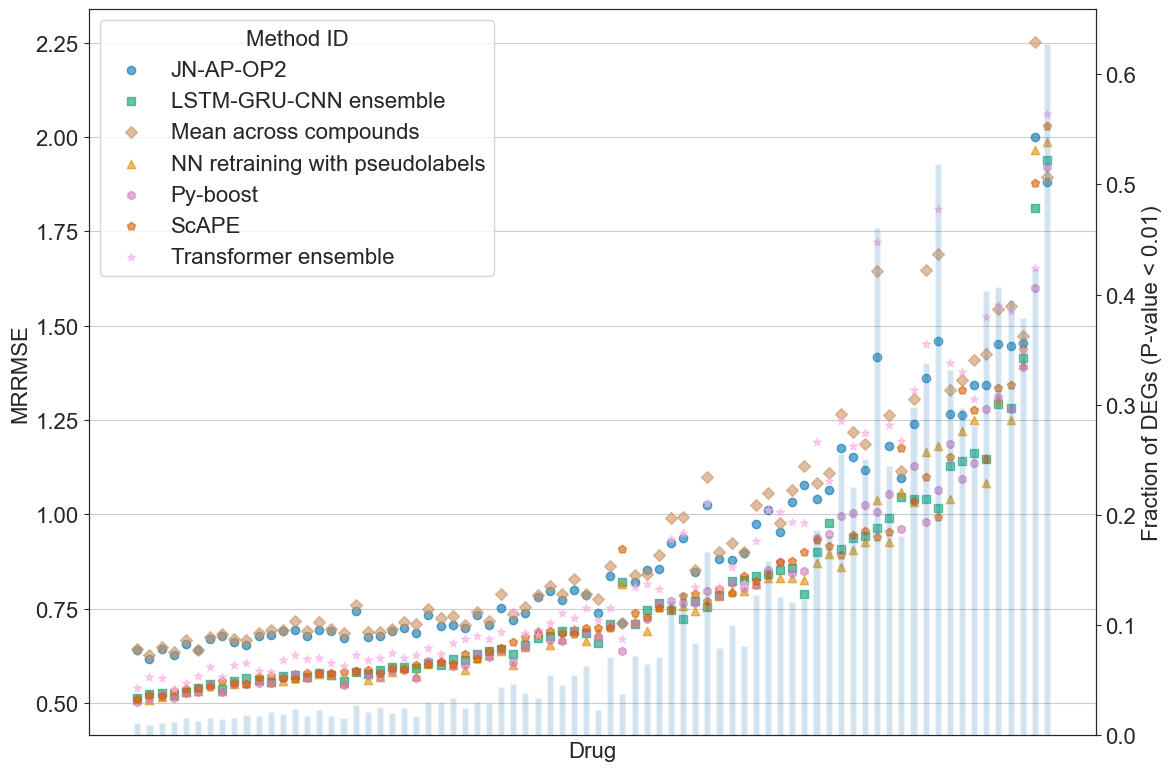

In [171]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
palette = sns.color_palette("colorblind")

sns.set_style("whitegrid")
sns.set_style("white")

# Set font size globally for the plot
matplotlib.rcParams.update({'font.size': 16})

# Add jitter to the x-axis categorical data for better visualization
# Assign a numeric value to each unique 'sm_name' for plotting
median_mrrmse = data.groupby('sm_name')['mrrmse'].median().sort_values()
categories = {name: i for i, name in enumerate(median_mrrmse.index)}
data['sm_jittered'] = data['sm_name'].map(categories)# + np.random.normal(0, 0.1, size=len(data))

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axis (primary axis)
ax2 = ax.twinx()  # Create another y-axis that shares the same x-axis (secondary axis)

# Plot bars on the secondary axis
total_genes_by_sm = data.drop_duplicates("sm_name").groupby('sm_name')['sig_genes'].sum().sort_values()
total_genes_10k = total_genes_by_sm / len(predictions["pyboost"].columns)
ax2.bar(categories.values(), total_genes_10k.loc[list(categories.keys())], alpha=0.2, label='Total Significant DEGs (10k)', width=0.5)

# Scatter plot on the primary axis
colors = {'JN-AP-OP2': 'blue', 'NN retraining with pseudolabels': 'green', "LSTM-GRU-CNN ensemble": 'red', "ScAPE": "orange", "Py-boost": "purple", "Mean across compounds": "black", "Transformer ensemble": "gray"}
# use colors from the palette
colors = {key: palette[i] for i, key in enumerate(colors.keys())}
markers = {'JN-AP-OP2': 'o', 'NN retraining with pseudolabels': '^', "LSTM-GRU-CNN ensemble": 's', "ScAPE": "p", "Py-boost": "h", "Mean across compounds": "D", "Transformer ensemble": "*"}
for method, group in data.groupby('method_id'):
    ax.scatter(group['sm_jittered'], group['mrrmse'], color=colors[method], marker=markers.get(method, 'o'), alpha=0.6, label=method)

# Axis and plot settings
ax.set_xticks([])  # Hide the x-axis labels
# plt.title('Per-drug MRRMSE with number of differentially expressed genes (DEGs)')
plt.title('')
ax.set_xlabel('Drug')
ax.set_ylabel('MRRMSE')
ax2.set_ylabel('Fraction of DEGs (P-value < 0.01)')
ax.legend(title='Method ID', loc='upper left')

# Grid settings
ax.grid(True)  # Enable grid for the primary axis
ax2.grid(False)  # Disable grid for the secondary axis

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.savefig("results_per_compound_reannotated.svg")
plt.show()

In [172]:
# load moa
moa_annotations = pd.read_csv(os.path.join("../data/complete_data", "moa_annotations.csv"))

In [173]:
data_top = data[data.method_id == "NN retraining with pseudolabels"].copy()

In [174]:
data_top["moa"] = data_top.sm_name.map(moa_annotations.set_index("sm_name")["moa"])

In [175]:
data_top[(data_top.sig_genes < 200) & (data_top.mrrmse > 0.6)].sm_name.unique()

array(['Atorvastatin', 'Canertinib', 'RN-486', 'RG7112', 'Lamivudine',
       'MGCD-265', 'Clemastine', 'Clotrimazole'], dtype=object)

In [176]:
data_top[(data_top.sig_genes < 200) & (data_top.mrrmse > 0.6)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
154,NN retraining with pseudolabels,Atorvastatin,0.626540,0.282476,0.434254,158,29,HMGCR inhibitor
182,NN retraining with pseudolabels,Canertinib,0.684164,0.454727,0.496079,125,38,unknown
184,NN retraining with pseudolabels,RN-486,0.689314,0.040665,0.485429,179,33,BTK inhibitor
195,NN retraining with pseudolabels,RG7112,0.814066,0.267763,0.577529,198,40,MDM2 inhibitor
196,NN retraining with pseudolabels,Lamivudine,0.603763,0.423083,0.428384,163,24,HIV reverse transcriptase inhibitor
203,NN retraining with pseudolabels,MGCD-265,0.612155,0.390043,0.432251,160,25,unknown
206,NN retraining with pseudolabels,Clemastine,0.600079,0.476806,0.417825,180,26,Histamine receptor antagonist
223,NN retraining with pseudolabels,Clotrimazole,0.619533,0.368488,0.433211,159,28,Cytochrome P450 inhibitor


In [177]:
# the above have high MRRMSE and low number of significant genes.

In [178]:
data_top[(data_top.sig_genes > 1400) & (data_top.mrrmse < 1.5)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
161,NN retraining with pseudolabels,Vorinostat,1.037003,0.816701,0.751563,2450,61,HDAC inhibitor
167,NN retraining with pseudolabels,BAY 61-3606,1.249001,0.662827,0.925544,2099,72,Syk inhibitor
170,NN retraining with pseudolabels,Dasatinib,1.032160,0.695725,0.735966,1587,64,Ephrin inhibitor
171,NN retraining with pseudolabels,AT13387,1.165600,0.722547,0.855121,1799,65,HSP inhibitor
181,NN retraining with pseudolabels,IMD-0354,1.221898,0.648896,0.886077,1578,68,IKK inhibitor
191,NN retraining with pseudolabels,Resminostat,1.181388,0.803976,0.850423,2756,66,HDAC inhibitor
205,NN retraining with pseudolabels,Bosutinib,1.039439,0.721832,0.755111,1764,67,Bcr-Abl tyrosine-kinase inhibitor
216,NN retraining with pseudolabels,Mometasone Furoate,1.304057,0.642895,0.953836,2166,71,Glucocorticoid receptor agonist
219,NN retraining with pseudolabels,PF-03814735,1.081886,0.760384,0.782323,2144,70,Aurora kinase inhibitor
221,NN retraining with pseudolabels,Prednisolone,1.251040,0.561456,0.901799,1496,69,Glucocorticoid receptor agonist


In [179]:
data_top[(data_top.sig_genes > 1400) & (data_top.mrrmse < 1.5)].sm_name.unique()

array(['Vorinostat', 'BAY 61-3606', 'Dasatinib', 'AT13387', 'IMD-0354',
       'Resminostat', 'Bosutinib', 'Mometasone Furoate', 'PF-03814735',
       'Prednisolone', 'Tacalcitol'], dtype=object)

In [180]:
# these 5 are exceptionally well predicted compounds

In [181]:
data_top[data_top.cosine_sim > 0.75]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
161,NN retraining with pseudolabels,Vorinostat,1.037003,0.816701,0.751563,2450,61,HDAC inhibitor
191,NN retraining with pseudolabels,Resminostat,1.181388,0.803976,0.850423,2756,66,HDAC inhibitor
202,NN retraining with pseudolabels,TPCA-1,0.860881,0.769631,0.631858,1360,58,IKK inhibitor
219,NN retraining with pseudolabels,PF-03814735,1.081886,0.760384,0.782323,2144,70,Aurora kinase inhibitor


In [182]:
# these compounds have directionality that's predicted well, even if the MRRMSE is not the best, potentially due to the high number of significant genes

In [183]:
data_top[(data_top.cosine_sim < 0.4) & (data_top.sig_genes > 1000)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
168,NN retraining with pseudolabels,LY2090314,1.964738,0.388021,1.458045,2257,74,GSK3 inhibitor
218,NN retraining with pseudolabels,Doxorubicin,1.986862,0.327508,1.513561,3338,75,unknown
222,NN retraining with pseudolabels,Tacalcitol,1.397652,0.355768,1.048618,2015,73,Vitamin D receptor agonist


In [184]:
# these compounds have a high number of significant genes, but the directionality is not predicted well

In [185]:
threshold = -np.log10(0.0001)

In [186]:
val = np.clip(de_test.iloc[:, 7:], -threshold, threshold).values.reshape(-1)
pred = np.clip(predictions["nn_retraining_with_pseudolabels"], -threshold, threshold).values.reshape(-1)
errors = val - pred

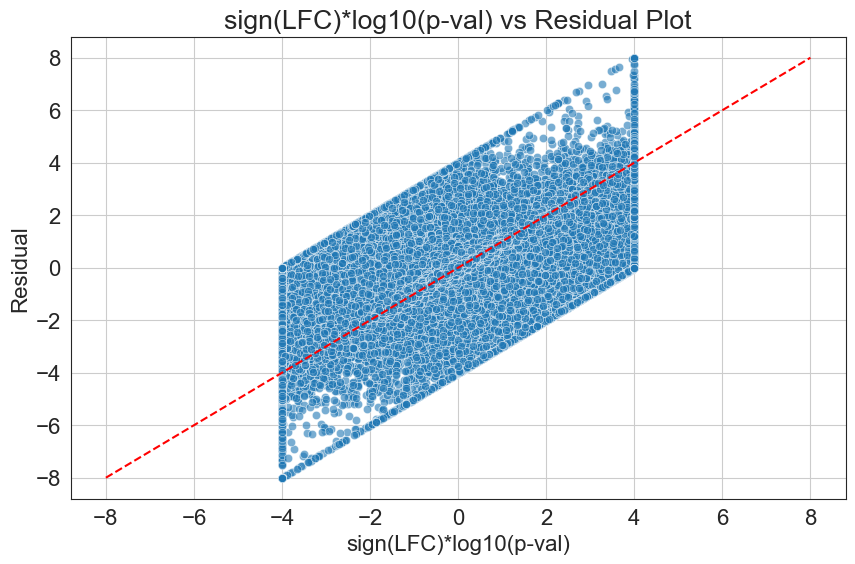

In [187]:
plt.figure(figsize=(10, 6))
plt.scatter(val, errors, alpha=0.6, edgecolors='w', linewidth=0.5)
x_y_line_range = [min(val.min(), errors.min()), max(val.max(), errors.max())]
plt.plot(x_y_line_range, x_y_line_range, 'r--', label='x=y Line')
plt.title('sign(LFC)*log10(p-val) vs Residual Plot')
plt.xlabel('sign(LFC)*log10(p-val)')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

In [188]:
import seaborn as sns

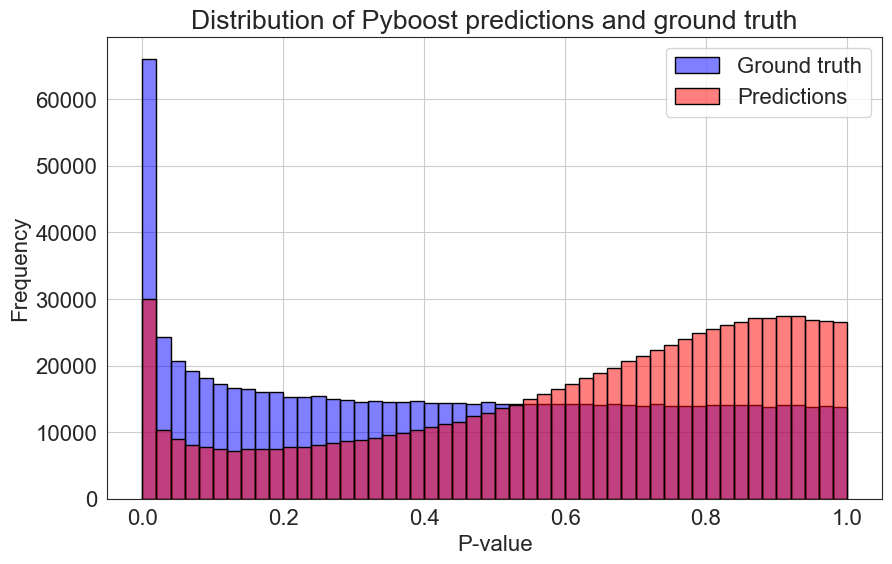

In [189]:
sns.set_style("whitegrid")
sns.set_style("white")
plt.figure(figsize=(10, 6))

sns.histplot(10**-np.abs(val), color='blue', bins=50, edgecolor='black', label='Ground truth', alpha=0.5)

# Plot histogram for val2
sns.histplot(10**-np.abs(pred), color='red', bins=50, edgecolor='black', label='Predictions', alpha=0.5)

# Adding labels and title
plt.title('Distribution of Pyboost predictions and ground truth')
plt.xlabel('P-value')
plt.ylabel('Frequency')

# Adding legend to distinguish the two distributions
plt.legend()

# Show plot with grid
plt.grid(True)
plt.show()

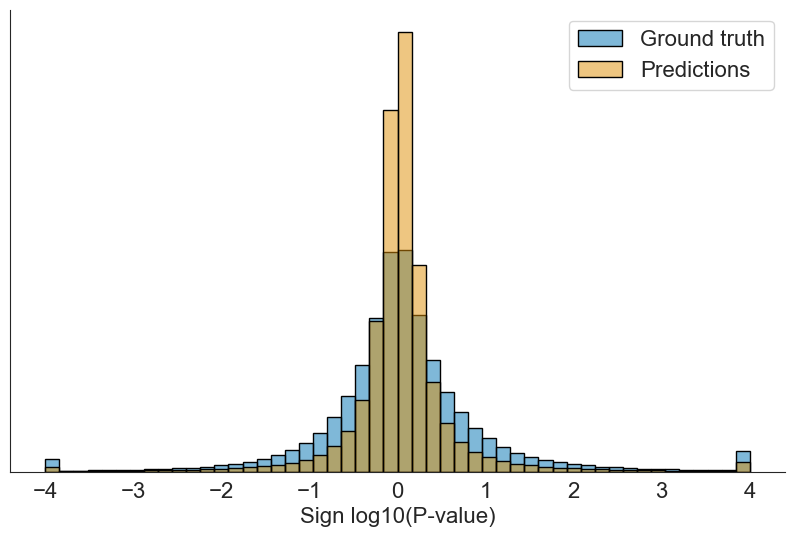

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("white")  # This will override the whitegrid if called after

# Initialize the figure with a specified size
plt.figure(figsize=(10, 6))

# Assuming 'val' and 'pred' are your data variables and 'palette' is defined
ax = sns.histplot(val, color=palette[0], bins=50, edgecolor='black', label='Ground truth', alpha=0.5)
sns.histplot(pred, color=palette[1], bins=50, edgecolor='black', label='Predictions', alpha=0.5)

# Set the title and labels
plt.title('')
plt.xlabel('Sign log10(P-value)')
plt.ylabel('')

# Hide y-axis ticks
plt.yticks([])

# Add legend
plt.legend()

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot with transparency
plt.savefig("predictions_vs_ground_truth.svg", transparent=True)

# Display the plot
plt.show()